In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME = '../webface-full-aligned-with-32-margin-resized/'

In [3]:
dataset = pd.read_csv('webface-full.aligned.train.csv', nrows=None)

In [4]:
encoder = LabelEncoder()
encoder.fit(dataset['person'])
dataset['person_id'] = encoder.transform(dataset['person'])

In [5]:
dataset.head()

,person,count,path,person_id
0,3331486,12,3331486/007.png,9650
1,3331486,12,3331486/002.png,9650
2,3331486,12,3331486/008.png,9650
3,3331486,12,3331486/006.png,9650
4,3331486,12,3331486/012.png,9650


In [6]:
np.mean(dataset.groupby('person_id')['person'].count())

42.87602836879432

In [7]:
# if the count > 30, will random pick 30 + (count-30)*0.2 imgs for the person
import random
random.seed(42)

FACE_NUM = 45

def crit(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < FACE_NUM: return True
    ratio = (FACE_NUM+(count-FACE_NUM)*0.4) / count
    return random.random() < ratio

def crit2(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < 6: return True
    return False
    
# dataset = dataset.select(crit)
dataset = pd.concat([dataset, dataset.select(crit2)], axis=0).reset_index()

In [8]:
np.mean(dataset.groupby('person_id')['person'].count())

42.881513002364066

In [9]:
y = dataset['person_id'].as_matrix()

In [23]:
y = np.concatenate([y,y])
y.shape

(906944,)

In [10]:
img_paths = [r.path for r in dataset.itertuples()]
print(len(img_paths))

453472


In [11]:
img_paths[0]

'3331486/007.png'

In [16]:
from PIL import Image

def path2ImgVec(path):
    x = img_to_array(load_img(join(DATA_HOME, path)).convert('L'))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(join(DATA_HOME, path)).convert('L')
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

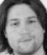

In [13]:
load_img(join(DATA_HOME, img_paths[0])).convert('L')

In [14]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()
del pool

In [17]:
pool = multiprocessing.Pool(8)
results2 = pool.map(path2ImgVecFlipped, img_paths)
pool.close()
pool.join()
del pool

In [18]:
X = np.vstack(results1+results2)

In [19]:
X.shape

(906944, 55, 47, 1)

In [31]:
for i in range(len(results1)): 
    results1[i] = None
del results1

NameError: name 'results1' is not defined

In [30]:
for i in range(len(results2)): 
    results2[i] = None
del results2

In [21]:
nb_class = len(np.unique(y))
print('nb_class', nb_class)
hidden_dim = 160
best_weights_filepath = '../models/best_weights.hdf5'
input_shape = X.shape[1:]

nb_class 10575


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [25]:
del X, y

In [32]:
import gc
gc.collect()

460

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.utils import np_utils
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from keras import metrics
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.engine import Model
from keras import optimizers

def build_model():
    image_input = Input(shape=input_shape)
    
    conv1 = Conv2D(20, (4, 4), name='conv1')(image_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)
#     pool1 = Dropout(rate=0.2)(pool1)
    
    conv2 = Conv2D(40, (3, 3), name='conv2')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
#     pool2 = Dropout(rate=0.2)(pool2)

    conv3 = Conv2D(60, (3, 3), name='conv3')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    flat1 = Flatten(name='flat1')(pool3)
    
    conv4 = Conv2D(80, (2, 2), name='conv4')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    flat2 = Flatten(name='flat2')(conv4)
    
    merged = concatenate([flat1, flat2])
    
    out = Dense(hidden_dim, name='hidden1')(merged)
    out = BatchNormalization()(out)
    out = Activation('relu',name='deepid')(out)
    out = Dense(nb_class, activation='softmax', name='softmax_class')(out)
    
    model = Model(inputs=image_input, outputs=out)

    # optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)

    model.compile(
        optimizer='adam', #rmsprop
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    print(model.summary())
    return model

In [34]:
model = None
# with tf.device('/gpu:0'):
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 55, 47, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 52, 44, 20)    340                                          
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 52, 44, 20)    80                                           
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 52, 44, 20)    0                                            
___________________________________________________________________________________________

In [35]:
saveBestModel = keras.callbacks.ModelCheckpoint(
    best_weights_filepath, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    mode='auto'
)
earlyStopping=keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='auto'
)

model.fit(
    X_train, 
    y_train, 
    batch_size=512, 
    epochs=8,
    verbose=2, 
    validation_split=0.1, 
    shuffle=True,
    callbacks=[saveBestModel, earlyStopping],
)

Train on 734624 samples, validate on 81625 samples
Epoch 1/8
129s - loss: 6.3583 - acc: 0.1267 - val_loss: 4.6270 - val_acc: 0.2662
Epoch 2/8
127s - loss: 3.5613 - acc: 0.4018 - val_loss: 4.9613 - val_acc: 0.2380
Epoch 3/8
134s - loss: 2.6495 - acc: 0.5311 - val_loss: 3.2033 - val_acc: 0.4552
Epoch 4/8
133s - loss: 2.1929 - acc: 0.5988 - val_loss: 3.4300 - val_acc: 0.4153
Epoch 5/8
126s - loss: 1.8974 - acc: 0.6441 - val_loss: 2.8118 - val_acc: 0.5165
Epoch 6/8
129s - loss: 1.6852 - acc: 0.6776 - val_loss: 2.7660 - val_acc: 0.5230
Epoch 7/8
126s - loss: 1.5234 - acc: 0.7021 - val_loss: 3.0257 - val_acc: 0.4847
Epoch 8/8
126s - loss: 1.3957 - acc: 0.7231 - val_loss: 2.5969 - val_acc: 0.5543


In [36]:
model.load_weights(best_weights_filepath)

In [37]:
model.save('../models/webface-full-simple-cnn.aligned.margin32.grey.model.h5')

In [38]:
model.evaluate(X_test, y_test, batch_size=512, verbose=2)

[2.61515496952333, 0.55190473565048992]

In [39]:
del X_train, X_test, y_train, y_test

In [40]:
del dataset

In [41]:
del encoder

In [42]:
import gc
gc.collect()

41